# Evaluate classification accuracy

This notebook demonstrates how to evaluate classification accuracy of "novel taxa". Due to the unique nature of this analysis, the metrics that we use to evaluate classification accuracy of "novel taxa" are different from those used for mock and simulated communities.

The key measure here is rate of ``match`` vs. ``overclassification``, hence P/R/F are not useful metrics. Instead, we define and measure the following as percentages:
* Match vs. overclassification rate
    * Match: assignment == L - 1 (e.g., a novel species is assigned the correct genus)
    * overclassification: assignment == L (e.g., correct genus but assigns to a near neighbor)
    * misclassification: incorrect assignment at L - 1 (e.g., wrong genus-level assignment)
    
Where ``L`` = taxonomic level being tested




## Functions

In [1]:
from tax_credit.framework_functions import novel_taxa_classification_evaluation
from tax_credit.eval_framework import parameter_comparisons
from tax_credit.plotting_functions import (pointplot_from_data_frame,
                                           heatmap_from_data_frame,
                                           per_level_kruskal_wallis,
                                           rank_optimized_method_performance_by_dataset)

from os.path import expandvars, join, exists
from glob import glob
from IPython.display import display, Markdown
import pandas as pd

## Evaluate classification results
First, enter in filepaths and directory paths where your data are stored, and the destination

In [9]:
project_dir = "../.."
analysis_name = "novel-taxa-simulations"
precomputed_results_dir = join(project_dir, "data", "precomputed-results", analysis_name)
expected_results_dir = join(project_dir, "data", analysis_name)
summary_fp = join(precomputed_results_dir, 'evaluate_classification_summary.csv')

results_dirs = glob(join(precomputed_results_dir, '*', '*', '*', '*'))

This cell performs the classification evaluation and should not be modified.

In [10]:
force = True
if force or not exists(summary_fp):
    accuracy_results = novel_taxa_classification_evaluation(results_dirs, expected_results_dir, summary_fp)
else:
    accuracy_results = pd.DataFrame.from_csv(summary_fp)

/Users/benkaehler/miniconda3/envs/qiime2-2017.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


# Plot classification accuracy
Finally, we plot our results. Line plots show the mean +/- 95% confidence interval for each classification result at each taxonomic level (1 = phylum, 6 = species) in each dataset tested. Do not modify the cell below, except to adjust the color_pallette used for plotting. This palette can be a dictionary of colors for each group, as shown below, or a [seaborn color palette](http://seaborn.pydata.org/tutorial/color_palettes.html).

**Precision** = Proportion of classifications that were correct. For novel taxa, this means a match at the last common ancestor (LCA) (level-1). True Positives / (True Positives + False Positives)

**Recall** = Proportion of reads that were correctly classified. Equals the number of exact matches to the LCA. True Positives / (True Positives + False Negatives)

**F-measure** = Harmonic mean of Precision and Recall

**overclassification_ratio** = proportion of taxa that were assigned to correct lineage but to a deeper taxonomic level than expected, rather than to LCA. E.g., assignment to another species in the clade

**underclassification_ratio** = proportion of assignments to correct lineage but to a lower level than expected.

**misclassification_ratio** = proportion of assignments to an incorrect lineage.

In [11]:
color_pallette={
    'rdp': 'seagreen', 'sortmerna': 'gray', 'vsearch': 'brown',
    'uclust': 'blue', 'blast': 'black', 'blast+': 'purple', 'q2-nb': 'pink',
    'naive-bayes': 'orange'
}

y_vars = ["Precision", "Recall", "F-measure",
          "overclassification_ratio", 
          "underclassification_ratio", "misclassification_ratio"]

## Plot per-level classification accuracy

For novel-taxa analysis, a separate classification is performed at each taxonomic level using different test (unique taxa at level L) and training sets (ref - test taxonomies). Hence, results at each level L represent independent tests, unlike for mock and simulated communities where each level represents the accuracy of each species-level classification trimmed to level L. For novel taxa, results at level L indicate the accuracy with with method M assigns the correct lineage to a "novel" taxon, which is unrepresented in the reference at level L, e.g., level 6 indicates the performance with which each classifier assigns the correct genus to each species. 

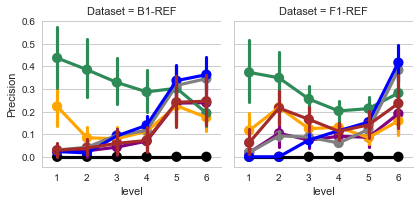

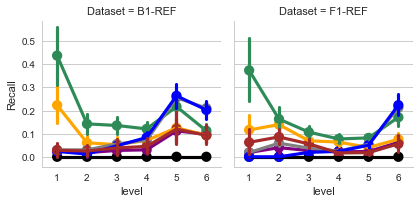

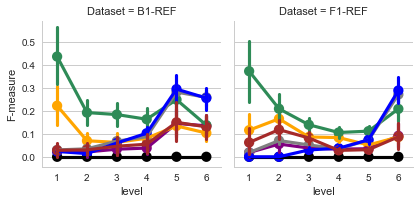

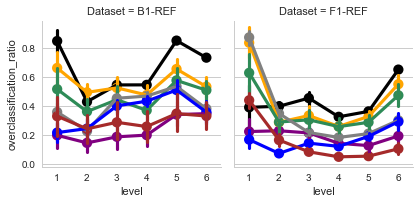

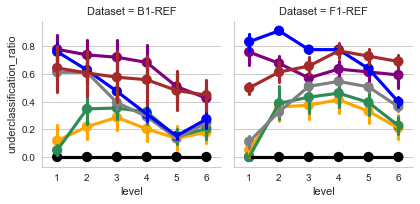

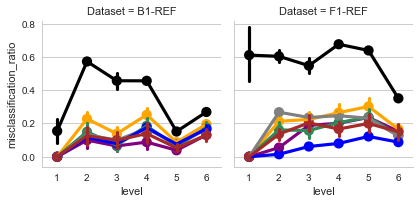

In [12]:
pointplot_from_data_frame(accuracy_results, "level", y_vars, 
                          group_by="Dataset", color_by="Method",
                          color_pallette=color_pallette)

## Per-level classification accuracy statistic
Kruskal-Wallis FDR-corrected p-values comparing classification methods at each level of taxonomic assignment

In [13]:
result = per_level_kruskal_wallis(accuracy_results, y_vars, group_by='Method', 
                                  dataset_col='Dataset', alpha=0.05, 
                                  pval_correction='fdr_bh')
result

Dataset                   Variable             1             2  \
0   B1-REF                  Precision  1.191956e-14  4.204817e-12   
1   B1-REF                     Recall  1.191956e-14  6.887185e-12   
2   B1-REF                  F-measure  1.191956e-14  9.321473e-12   
3   B1-REF   overclassification_ratio  3.409840e-12  9.245160e-10   
4   B1-REF  underclassification_ratio  3.875958e-31  9.079767e-16   
5   B1-REF    misclassification_ratio  2.453287e-38  2.918290e-10   
6   F1-REF                  Precision  8.185711e-16  2.594176e-15   
7   F1-REF                     Recall  8.185711e-16  1.496161e-15   
8   F1-REF                  F-measure  8.185711e-16  1.963975e-15   
9   F1-REF   overclassification_ratio  8.326464e-30  1.028429e-21   
10  F1-REF  underclassification_ratio  4.252794e-42  7.988814e-34   
11  F1-REF    misclassification_ratio  1.037506e-59  1.277791e-35   

               3             4             5             6  
0   1.082535e-08  1.247129e-07  2.979004e-04  2.707197e-05  
1   6.931703e-08  5.995407e-08  1.066668e-06  2.837692e-09  
2   3.387801e-08  2.601273e-08  4.416884e-06  6.483652e-09  
3   6.987651e-08  1.382397e-08  5.995407e-08  2.083937e-06  
4   3.310764e-12  3.798387e-11  1.963975e-15  1.475388e-11  
5   3.025621e-09  1.603338e-12  2.919643e-11  9.550915e-05  
6   5.036855e-10  1.925243e-09  6.711985e-07  1.904753e-05  
7   1.820747e-12  8.834594e-13  6.476972e-09  7.328503e-09  
8   1.475388e-11  2.830863e-11  3.327527e-08  4.548083e-08  
9   2.658030e-15  7.882352e-19  3.265969e-21  7.332614e-17  
10  3.573754e-21  3.542268e-22  3.519787e-19  1.925695e-26  
11  1.566345e-23  1.106677e-22  6.461247e-17  1.314765e-12

## Heatmaps of method accuracy by parameter
Heatmaps show the performance of individual method/parameter combinations at each taxonomic level, in each reference database (i.e., for bacterial and fungal novel-taxa datasets individually).

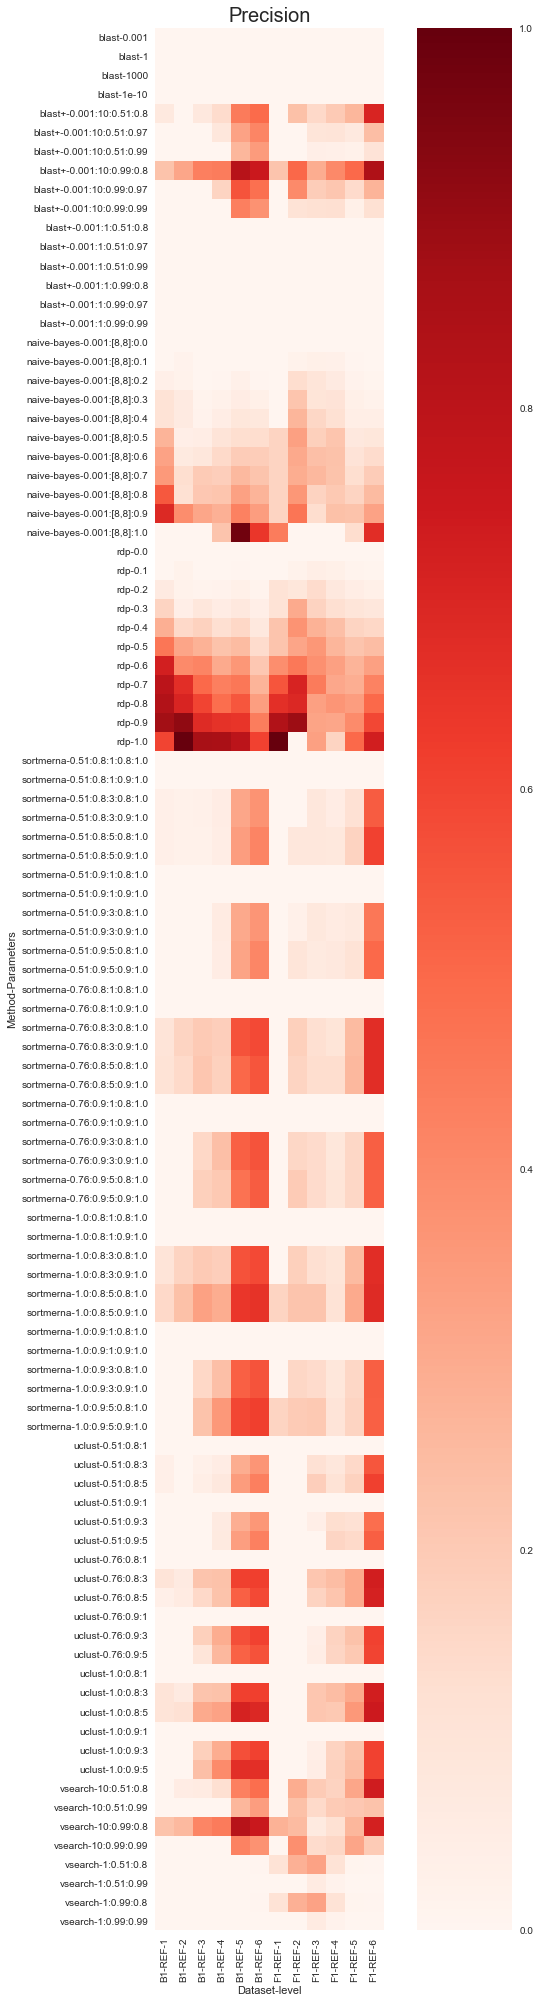

In [14]:
heatmap_from_data_frame(accuracy_results, metric="Precision", rows=["Method", "Parameters"], cols=["Dataset", "level"])

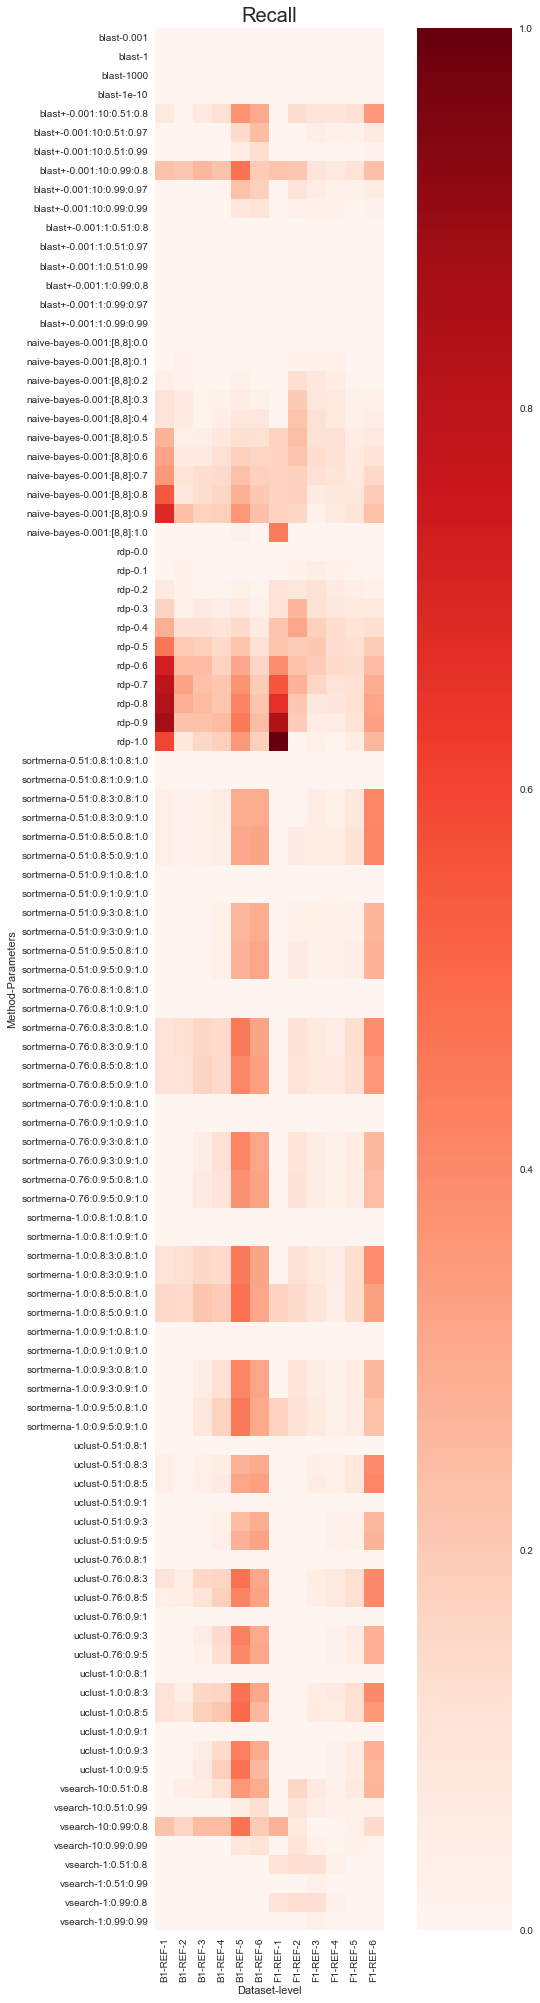

In [15]:
heatmap_from_data_frame(accuracy_results, metric="Recall", rows=["Method", "Parameters"], cols=["Dataset", "level"])

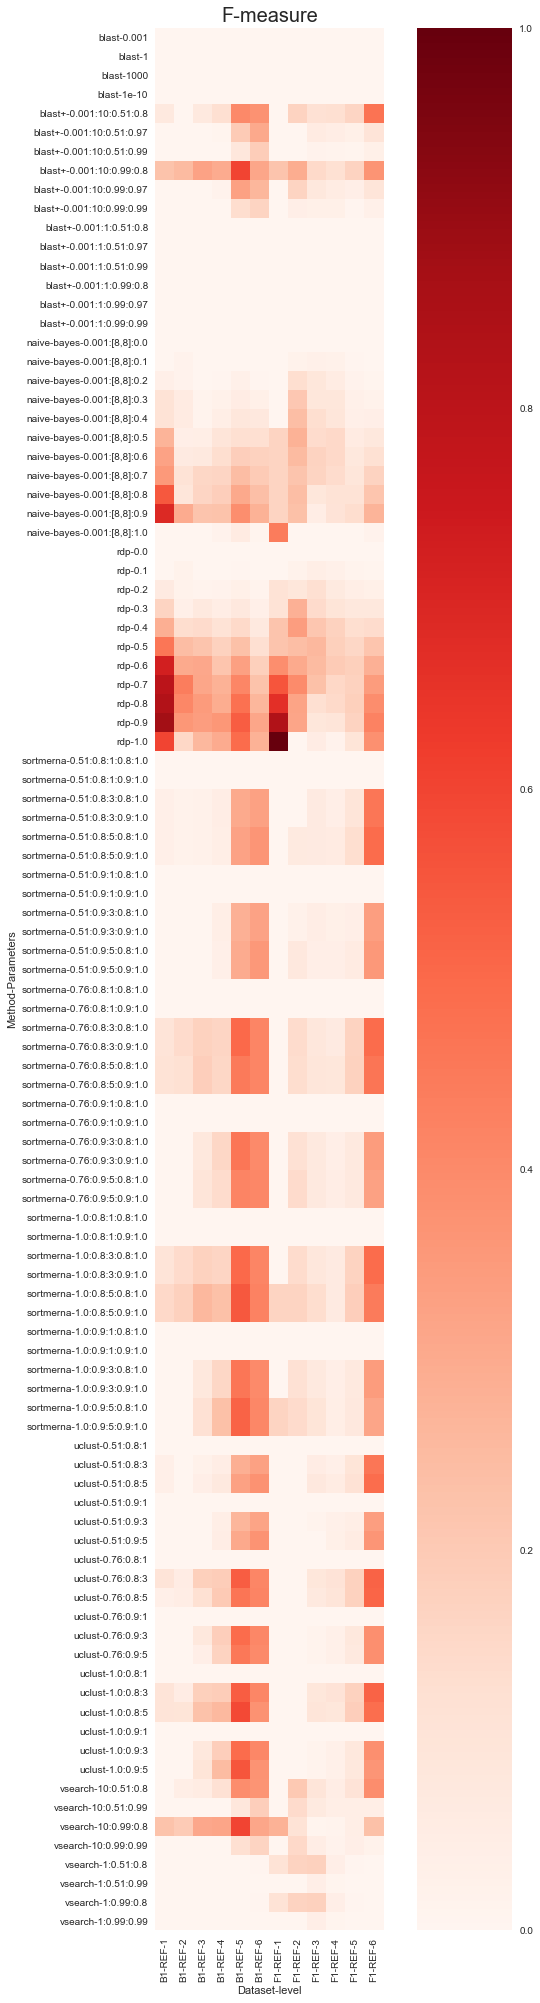

In [16]:
heatmap_from_data_frame(accuracy_results, metric="F-measure", rows=["Method", "Parameters"], cols=["Dataset", "level"])

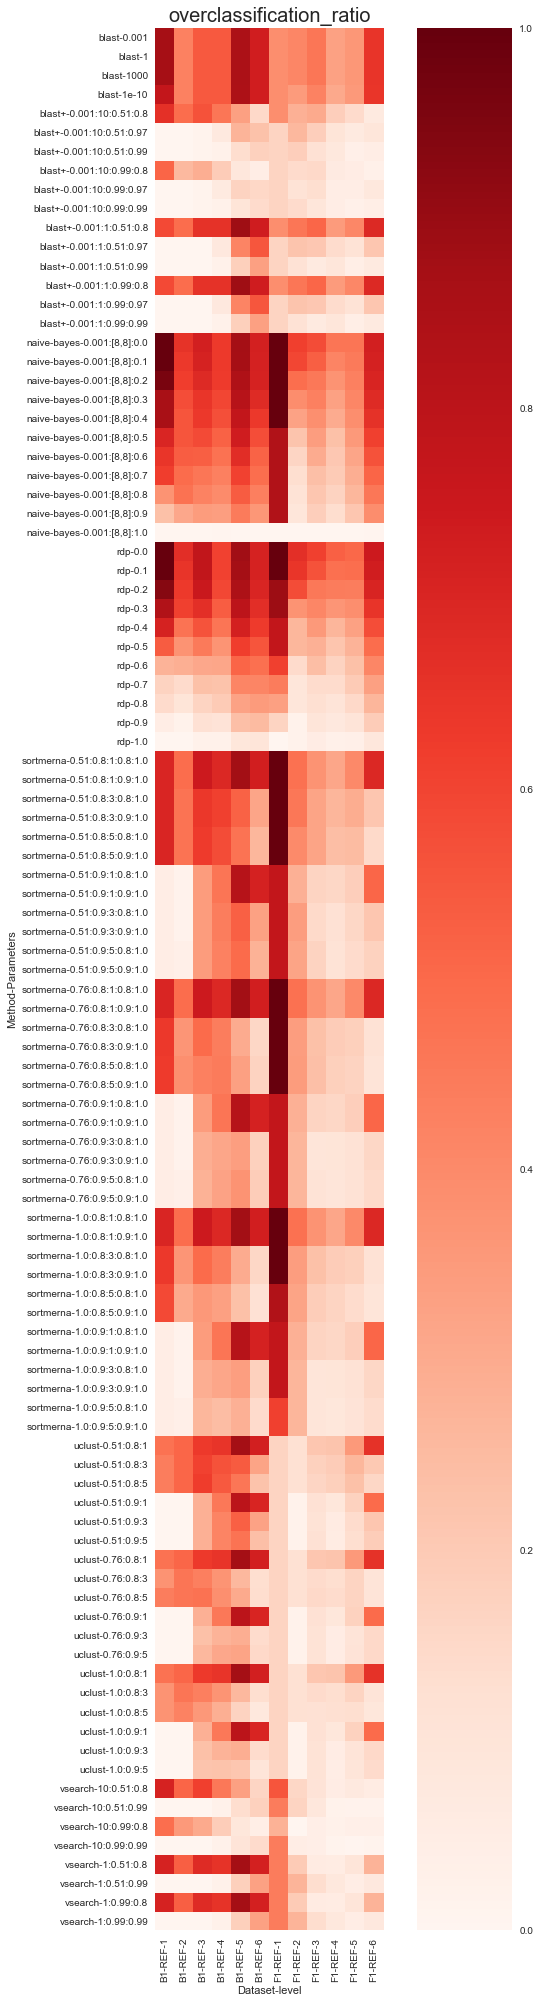

In [17]:
heatmap_from_data_frame(accuracy_results, metric="overclassification_ratio", rows=["Method", "Parameters"], cols=["Dataset", "level"])

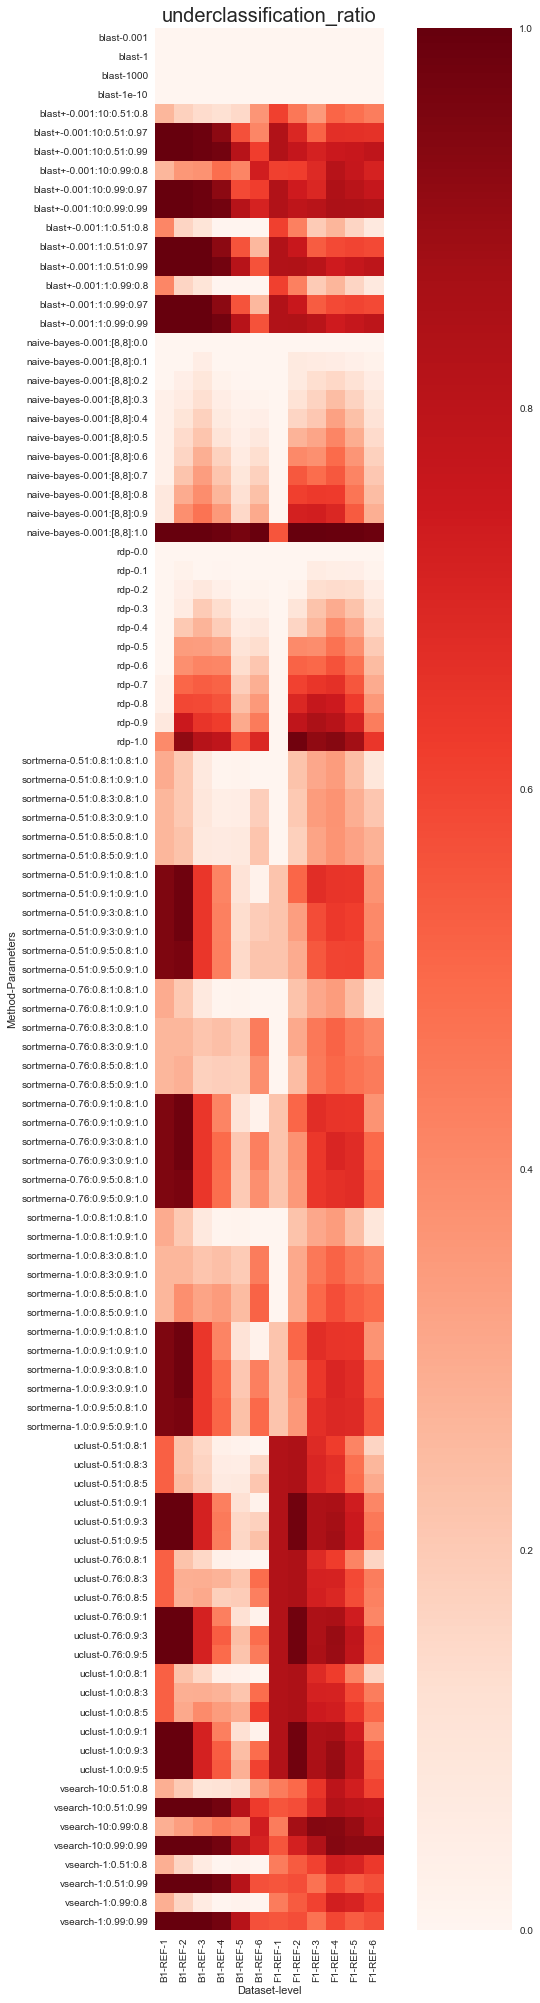

In [18]:
heatmap_from_data_frame(accuracy_results, metric="underclassification_ratio", rows=["Method", "Parameters"], cols=["Dataset", "level"])

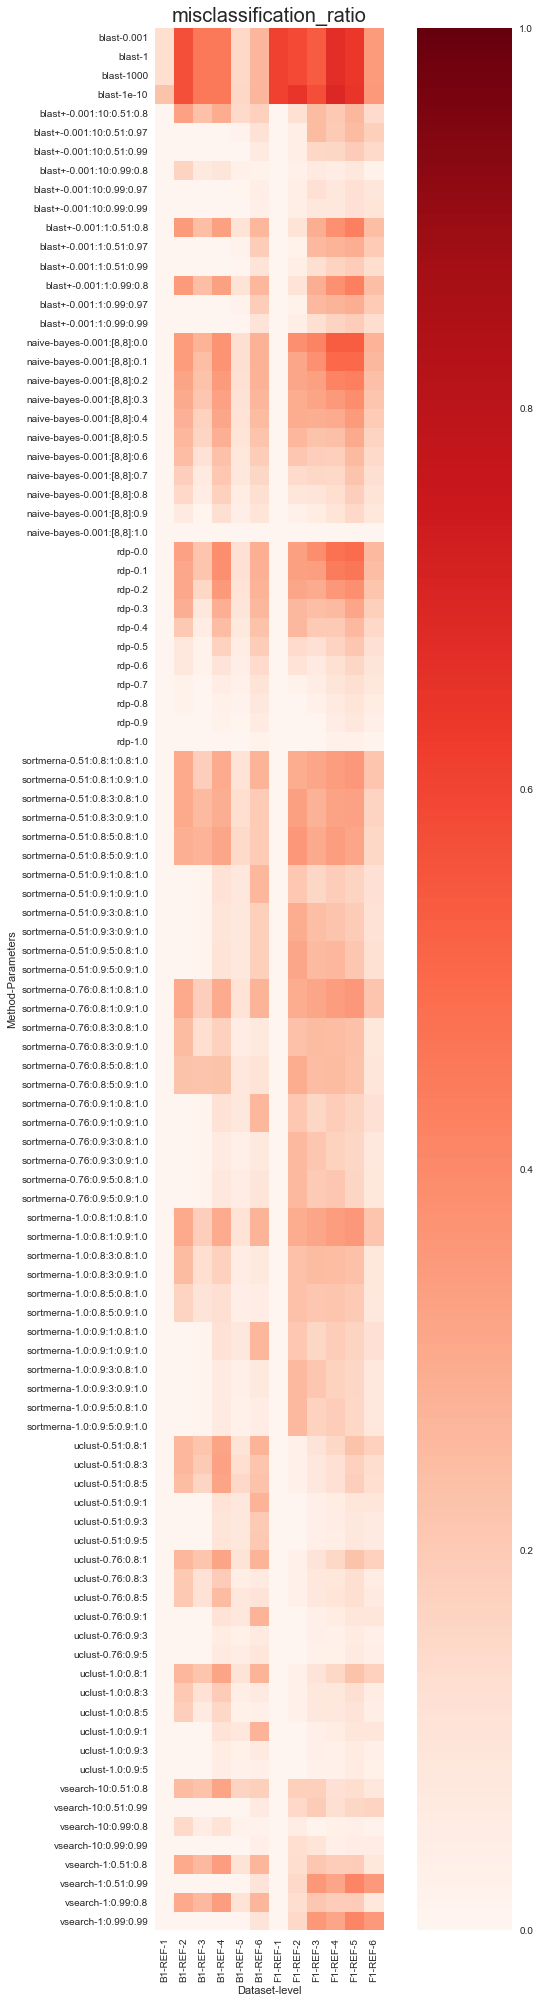

In [19]:
heatmap_from_data_frame(accuracy_results, metric="misclassification_ratio", rows=["Method", "Parameters"], cols=["Dataset", "level"])

## Rank-based statistics comparing the performance of the optimal parameter setting run for each method on each data set.
Rank parameters for each method to determine the best parameter configuration within each method. *Count best* values in each column indicate how many samples a given method achieved within one mean absolute deviation of the best result (which is why they may sum to more than the total number of samples).

In [20]:
for method in accuracy_results['Method'].unique():
    top_params = parameter_comparisons(accuracy_results[accuracy_results["level"] == 6], 
                                       method, metrics=["Precision", "Recall", 
                                                        "overclassification_ratio", 
                                                        "underclassification_ratio", 
                                                        "misclassification_ratio",
                                                        "F-measure"],
                                       ascending={"Precision": False, "Recall": False, 
                                                        "overclassification_ratio": True, 
                                                        "underclassification_ratio": True, 
                                                        "misclassification_ratio": True,
                                                        "F-measure": False},
                                       sample_col='Dataset', method_col='Method',
                                       dataset_col='Dataset')
    display(Markdown('## {0}'.format(method)))
    display(top_params[:5])

## blast

F-measure  Precision  Recall  misclassification_ratio  \
0.001          6          6       6                        2   
1              6          6       6                        2   
1000           6          6       6                        2   
1e-10          6          6       6                        2   

       overclassification_ratio  underclassification_ratio  
0.001                         1                          6  
1                             1                          6  
1000                          1                          6  
1e-10                         2                          6

## blast+

F-measure  Precision  Recall  misclassification_ratio  \
0.001:10:0.51:0.8         6.0        3.0     6.0                      0.0   
0.001:10:0.99:0.8         4.0        6.0     1.0                      6.0   
0.001:10:0.51:0.97        3.0        0.0     3.0                      0.0   
0.001:10:0.99:0.97        1.0        1.0     1.0                      3.0   
0.001:10:0.51:0.99        0.0        0.0     0.0                      3.0   

                    overclassification_ratio  underclassification_ratio  
0.001:10:0.51:0.8                        6.0                        0.0  
0.001:10:0.99:0.8                        6.0                        0.0  
0.001:10:0.51:0.97                       6.0                        0.0  
0.001:10:0.99:0.97                       6.0                        0.0  
0.001:10:0.51:0.99                       6.0                        0.0

## naive-bayes

F-measure  Precision  Recall  misclassification_ratio  \
0.001:[8,8]:0.9        6.0        0.0     6.0                      0.0   
0.001:[8,8]:0.8        5.0        0.0     6.0                      0.0   
0.001:[8,8]:0.7        2.0        0.0     3.0                      0.0   
0.001:[8,8]:0.0        0.0        0.0     0.0                      0.0   
0.001:[8,8]:0.1        0.0        0.0     0.0                      0.0   

                 overclassification_ratio  underclassification_ratio  
0.001:[8,8]:0.9                       0.0                        0.0  
0.001:[8,8]:0.8                       0.0                        0.0  
0.001:[8,8]:0.7                       0.0                        2.0  
0.001:[8,8]:0.0                       0.0                        6.0  
0.001:[8,8]:0.1                       0.0                        6.0

## rdp

F-measure  Precision  Recall  misclassification_ratio  \
0.8        6.0        0.0     6.0                      6.0   
0.9        6.0        3.0     6.0                      6.0   
1.0        6.0        6.0     5.0                      6.0   
0.7        4.0        0.0     6.0                      4.0   
0.6        1.0        0.0     4.0                      0.0   

     overclassification_ratio  underclassification_ratio  
0.8                       2.0                        0.0  
0.9                       6.0                        0.0  
1.0                       6.0                        0.0  
0.7                       0.0                        0.0  
0.6                       0.0                        0.0

## sortmerna

F-measure  Precision  Recall  misclassification_ratio  \
1.0:0.8:3:0.9:1.0         6.0        6.0     6.0                      6.0   
0.51:0.9:5:0.8:1.0        6.0        3.0     4.0                      0.0   
0.76:0.9:3:0.8:1.0        6.0        6.0     3.0                      6.0   
1.0:0.8:5:0.9:1.0         6.0        6.0     6.0                      6.0   
0.76:0.8:5:0.9:1.0        6.0        6.0     6.0                      5.0   

                    overclassification_ratio  underclassification_ratio  
1.0:0.8:3:0.9:1.0                        6.0                        0.0  
0.51:0.9:5:0.8:1.0                       6.0                        0.0  
0.76:0.9:3:0.8:1.0                       6.0                        0.0  
1.0:0.8:5:0.9:1.0                        6.0                        0.0  
0.76:0.8:5:0.9:1.0                       6.0                        0.0

## uclust

F-measure  Precision  Recall  misclassification_ratio  \
1.0:0.9:5         6.0        6.0     4.0                      6.0   
1.0:0.8:3         6.0        6.0     6.0                      6.0   
0.51:0.8:5        6.0        3.0     6.0                      0.0   
1.0:0.9:3         6.0        6.0     6.0                      6.0   
0.51:0.9:5        6.0        3.0     6.0                      3.0   

            overclassification_ratio  underclassification_ratio  
1.0:0.9:5                        6.0                        0.0  
1.0:0.8:3                        6.0                        0.0  
0.51:0.8:5                       6.0                        0.0  
1.0:0.9:3                        6.0                        0.0  
0.51:0.9:5                       6.0                        0.0

## vsearch

F-measure  Precision  Recall  misclassification_ratio  \
10:0.51:0.8         6.0        3.0     5.0                        3   
10:0.99:0.8         3.0        6.0     1.0                        6   
10:0.51:0.99        0.0        0.0     0.0                        3   
10:0.99:0.99        0.0        0.0     0.0                        6   
1:0.51:0.8          0.0        0.0     0.0                        3   

              overclassification_ratio  underclassification_ratio  
10:0.51:0.8                        6.0                        2.0  
10:0.99:0.8                        6.0                        0.0  
10:0.51:0.99                       6.0                        0.0  
10:0.99:0.99                       6.0                        0.0  
1:0.51:0.8                         0.0                        6.0

## Rank performance of optimized methods
Now we rank the top-performing method/parameter combination for each method at species level. Methods are ranked by top F-measure, and the average value for each metric is shown (rather than count best as above). F-measure distributions are plotted for each method, and compared using paired t-tests with FDR-corrected P-values. This cell does not need to be altered, unless if you wish to change the *metric* used for sorting best methods and for plotting.

## B1-REF level 6

Method         Parameters  Precision    Recall  F-measure  \
4    sortmerna  1.0:0.8:5:0.8:1.0   0.655971  0.312642   0.423304   
5       uclust         0.76:0.8:5   0.588096  0.325494   0.418949   
1       blast+  0.001:10:0.51:0.8   0.498477  0.304266   0.377878   
6      vsearch        10:0.51:0.8   0.486433  0.298671   0.370055   
3          rdp                0.9   0.440478  0.242460   0.312760   
2  naive-bayes    0.001:[8,8]:0.9   0.343214  0.236328   0.279890   
0        blast              0.001   0.000000  0.000000   0.000000   

   overclassification_ratio  underclassification_ratio  \
4                  0.117930                   0.518544   
5                  0.136205                   0.434570   
1                  0.149445                   0.366501   
6                  0.163164                   0.354123   
3                  0.250488                   0.447655   
2                  0.360511                   0.304671   
0                  0.730808                   0.000000   

   misclassification_ratio  
4                 0.050884  
5                 0.103731  
1                 0.178379  
6                 0.183104  
3                 0.059397  
2                 0.098022  
0                 0.269192

stat             P     FDR P
Method A    Method B                                        
blast       blast+       -135.974223  5.408186e-05  0.000568
            naive-bayes -1607.067622  3.871965e-07  0.000008
            rdp           -44.377598  5.073899e-04  0.002590
            sortmerna     -64.010953  2.439678e-04  0.001708
            uclust        -33.907064  8.686673e-04  0.002606
            vsearch       -40.247951  6.167519e-04  0.002590
blast+      naive-bayes    35.752096  7.814257e-04  0.002606
            rdp             7.218273  1.865715e-02  0.026120
            sortmerna      -5.346789  3.324501e-02  0.043634
            uclust         -3.041175  9.324625e-02  0.103062
            vsearch         0.847345  4.860320e-01  0.510334
naive-bayes rdp            -4.734600  4.183092e-02  0.051673
            sortmerna     -21.161653  2.225610e-03  0.005842
            uclust        -11.388581  7.622075e-03  0.016006
            vsearch        -9.994551  9.863044e-03  0.017260
rdp         sortmerna     -10.005599  9.841596e-03  0.017260
            uclust        -17.282230  3.331394e-03  0.007773
            vsearch        -8.673189  1.303425e-02  0.020891
sortmerna   uclust          0.253685  8.234358e-01  0.823436
            vsearch         3.457665  7.442625e-02  0.086831
uclust      vsearch         8.384876  1.392707e-02  0.020891

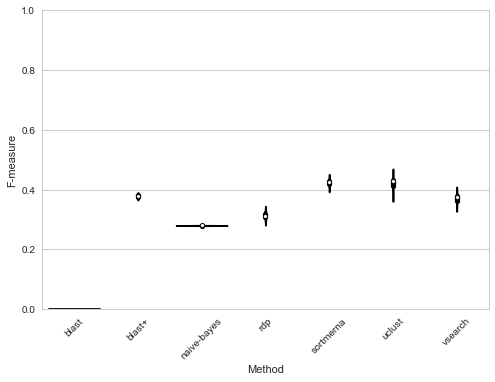

## F1-REF level 6

Method         Parameters  Precision    Recall  F-measure  \
5       uclust          1.0:0.8:3   0.727888  0.402913   0.518689   
4    sortmerna  1.0:0.8:3:0.9:1.0   0.675696  0.388649   0.493440   
1       blast+  0.001:10:0.51:0.8   0.703189  0.352098   0.469214   
3          rdp                0.9   0.592356  0.330554   0.424299   
6      vsearch        10:0.51:0.8   0.735864  0.268488   0.392185   
2  naive-bayes    0.001:[8,8]:0.9   0.325981  0.230445   0.270009   
0        blast              0.001   0.000000  0.000000   0.000000   

   overclassification_ratio  underclassification_ratio  \
5                  0.103166                   0.438252   
4                  0.115928                   0.408362   
1                  0.066806                   0.440073   
3                  0.194068                   0.438262   
6                  0.056058                   0.599296   
2                  0.394046                   0.285812   
0                  0.649630                   0.000000   

   misclassification_ratio  
5                 0.055670  
4                 0.087061  
1                 0.141023  
3                 0.037116  
6                 0.076159  
2                 0.089696  
0                 0.350370

stat         P     FDR P
Method A    Method B                                   
blast       blast+      -110.352684  0.000082  0.000511
            naive-bayes  -21.244833  0.002208  0.005797
            rdp         -101.397926  0.000097  0.000511
            sortmerna   -167.028283  0.000036  0.000376
            uclust      -234.682138  0.000018  0.000376
            vsearch      -14.596769  0.004661  0.008156
blast+      naive-bayes   15.624563  0.004071  0.007772
            rdp            6.353974  0.023885  0.033439
            sortmerna     -4.604098  0.044079  0.057854
            uclust        -7.748338  0.016252  0.024377
            vsearch        3.382454  0.077394  0.081264
naive-bayes rdp          -16.286546  0.003749  0.007772
            sortmerna    -22.736972  0.001929  0.005786
            uclust       -19.842714  0.002530  0.005904
            vsearch       -3.972248  0.057925  0.067579
rdp         sortmerna    -38.144871  0.000687  0.002884
            uclust       -29.998664  0.001109  0.003883
            vsearch        1.083547  0.391810  0.391810
sortmerna   uclust        -8.414831  0.013830  0.022341
            vsearch        3.636451  0.067999  0.075156
uclust      vsearch        4.351320  0.048968  0.060490

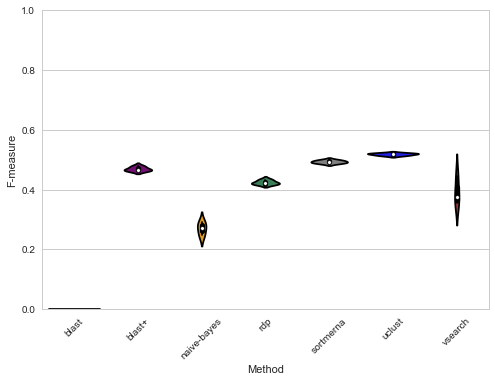

In [21]:
rank_optimized_method_performance_by_dataset(accuracy_results, dataset="Dataset",
                                             metric="F-measure",
                                             level="level",
                                             level_range=range(6,7),
                                             display_fields=["Method",
                                                             "Parameters",
                                                             "Precision",
                                                             "Recall",
                                                             "F-measure",
                                                             "overclassification_ratio",
                                                             "underclassification_ratio",
                                                             "misclassification_ratio"],
                                             paired=True,
                                             parametric=True,
                                             color=None,
                                             color_pallette=color_pallette)